<a href="https://colab.research.google.com/github/patrickabadi/python-pytorch-notebooks/blob/main/time_series_sklearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html

In [ ]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

!pip install skforecast

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

# Warnings configuration
# ==============================================================================
import warnings
# warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Data download
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv'
data = pd.read_csv(url, sep=',')
data

,fecha,y,exog_1,exog_2
0,1992-04-01,0.379808,0.958792,1.166029
1,1992-05-01,0.361801,0.951993,1.117859
2,1992-06-01,0.410534,0.952955,1.067942
3,1992-07-01,0.483389,0.958078,1.097376
4,1992-08-01,0.475463,0.956370,1.122199
...,...,...,...,...
190,2008-02-01,0.761822,1.515840,1.786373
191,2008-03-01,0.649435,1.506258,1.694264
192,2008-04-01,0.827887,1.505253,1.627135
193,2008-05-01,0.816255,1.491464,1.555068


In [ ]:
# Data preparation
# ==============================================================================
data = data.rename(columns={'fecha': 'date'})
data['date'] = pd.to_datetime(data['date'], format='%Y/%m/%d')
data = data.set_index('date')
data = data.rename(columns={'x': 'y'})
data = data.asfreq('MS')
data = data.sort_index()
data.head()

,y,exog_1,exog_2
date,,,
1992-04-01,0.379808,0.958792,1.166029
1992-05-01,0.361801,0.951993,1.117859
1992-06-01,0.410534,0.952955,1.067942
1992-07-01,0.483389,0.958078,1.097376
1992-08-01,0.475463,0.956370,1.122199


In [ ]:
print(f'Number of rows with missing values: {data.isnull().any(axis=1).mean()}')

Number of rows with missing values: 0.0


In [ ]:
# Verify that a temporary index is complete
# ==============================================================================
(data.index == pd.date_range(start=data.index.min(),
                             end=data.index.max(),
                             freq=data.index.freq)).all()

True

In [ ]:
# Fill gaps in a temporary index
# ==============================================================================
# data.asfreq(freq='30min', fill_value=np.nan)

Train dates : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Test dates  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


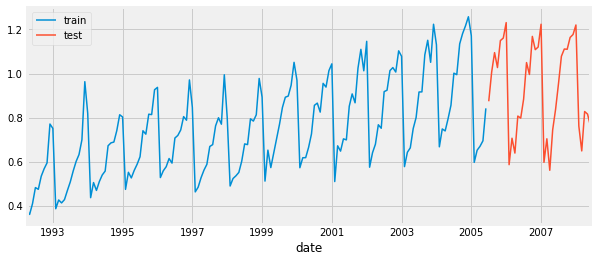

In [ ]:
# Split data into train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax=plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
ax.legend();

In [ ]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 6
             )

forecaster.fit(y=data_train['y'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-03-05 19:18:36 
Last fit date: 2023-03-05 19:18:36 
Skforecast version: 0.6.0 
Python version: 3.8.10 

In [ ]:
# Predictions
# ==============================================================================
# Once the model is trained, the test data is predicted (36 months into the future).

steps = 36
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2005-07-01    0.878756
2005-08-01    0.882167
2005-09-01    0.973184
2005-10-01    0.983678
2005-11-01    0.849494
Freq: MS, Name: pred, dtype: float64

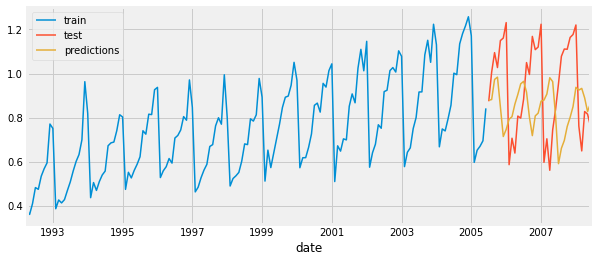

In [ ]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [ ]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 0.07326833976120374


In [ ]:
# Hyperparameter Grid search
# ==============================================================================
steps = 36
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # This value will be replaced in the grid search
             )

# Lags used as predictors
lags_grid = [10, 20]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data_train['y'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

Number of models compared: 12.


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:53<00:00, 26.86s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 0.012836389345193383



In [ ]:
# Grid Search results
# ==============================================================================
results_grid

,lags,params,mean_squared_error,max_depth,n_estimators
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 500}",0.012836,3,500
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",0.012858,3,100
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 500}",0.013248,5,500
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",0.013364,5,100
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 500}",0.013435,10,500
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",0.014028,10,100
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 100}",0.036982,3,100
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 500}",0.037345,3,500
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 500}",0.037574,5,500
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 500}",0.040542,10,500


In [ ]:
# Create and train forecaster with the best hyperparameters
# ==============================================================================
regressor = RandomForestRegressor(max_depth=3, n_estimators=500, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 20
             )

forecaster.fit(y=data_train['y'])

In [ ]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps)

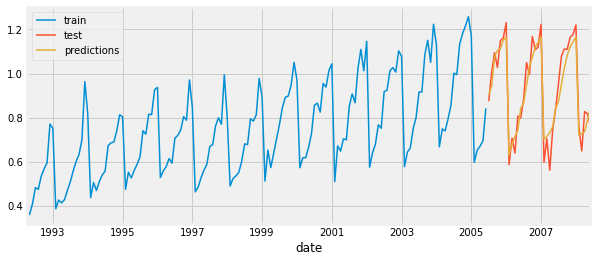

In [ ]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [ ]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 0.004392699665157793
